In [1]:
import numpy as np
from itertools import permutations
import pandas as pd
import matplotlib.pyplot as plt
# from tqdm import tqdm
import multiprocessing as mp
from multiprocessing import Pool, cpu_count
from threading import Thread
import random  
from tools import *
from utility_anisotropic import *
from typing import List, Tuple, Set, Optional
import itertools
random.seed(42)  



In [2]:
# stab   = ['ZZXIZZ', 'YZZYZI', 'YZIZYZ', 'XXIIII', 'ZZZZIX'] #_6_1_3 
input_stabilizers_list = ['ZXZIZZ','ZZXIZZ','YZZYIZ', 'XIIZXZ','IZZZZX'] #_6_1_3 
# input_stabilizers_list   = ['XXIIIII', 'IIXIIZI', 'IIIXIIZ', 'IIIIXIZ', 'ZZZIIXI', 'YZIZZZY'] #_7_1_3
# input_stabilizers_list = ['XXIIIIII', 'XIXIIIII', 'IIIXIIZI', 'IIIIXIIZ', 'IIIIIXIZ', 'ZZZZIIXI', 'YZZIZZZY'] #_8_1_3

Logical_x = 'ZIIZZI'
Logical_z = 'ZIIXIZ'
number_of_qubits = len(input_stabilizers_list[0])  # number of qubits
message_qubits = len(input_stabilizers_list)  # number of stabilizers

In [3]:
def pauli_stabilizers_to_binary_matrix(stabilizers):
    """
    Input:
    - stabilizers: A list of strings. Each string contains only 'I', 'X', 'Y', or 'Z',
      representing a Pauli operator on n qubits.

    Output:
    - A binary matrix (NumPy array) of shape (number of stabilizers, 2 * n).
      First n columns represent X components, next n columns represent Z components.
    """
    if not isinstance(stabilizers, list) or not all(isinstance(s, str) for s in stabilizers):
        raise TypeError("Input must be a list of strings")

    num_stabilizers = len(stabilizers)
    num_qubits = len(stabilizers[0])
    binary_matrix = np.zeros((num_stabilizers, 2 * num_qubits), dtype=int)

    for row_idx, op_string in enumerate(stabilizers):
        for qubit_idx, op in enumerate(op_string):
            if op == 'X':
                binary_matrix[row_idx, qubit_idx] = 1
            elif op == 'Z':
                binary_matrix[row_idx, num_qubits + qubit_idx] = 1
            elif op == 'Y':
                binary_matrix[row_idx, qubit_idx] = 1
                binary_matrix[row_idx, num_qubits + qubit_idx] = 1
            elif op == 'I':
                continue
            else:
                raise ValueError("Invalid character in stabilizer. Use only 'I', 'X', 'Y', or 'Z'.")

    return binary_matrix

def new_parity_check(original_matrix):
    """
    Given a binary stabilizer matrix, constructs an extended parity check matrix.
    - Splits the input matrix into two halves (matrix1, matrix2).
    - Returns a new matrix by horizontally stacking the original matrix and the bitwise sum (mod 2) of the two halves.
    This is often used in quantum error correction to generate new parity checks from existing stabilizer matrices.
    """
    m, two_n = original_matrix.shape  # Get dimensions of the original matrix
    n = two_n // 2  # Calculate n

    # Split the original matrix into two matrices
    matrix1 = original_matrix[:, :n]  # First n columns
    matrix2 = original_matrix[:, n:]   # Last n columns
    return np.hstack((original_matrix, (matrix1 + matrix2) % 2))

In [4]:
complete_parity_matrix = new_parity_check(pauli_stabilizers_to_binary_matrix(input_stabilizers_list))

In [5]:

def weight(pauli_string):
    """
    Input: pauli_string (str) – Pauli operator string with 'I', 'X', 'Y', 'Z'
    Output: int – Number of non-'I' characters
    """
    return sum(1 for char in pauli_string if char != 'I')


In [6]:
# -------------------------
# Helper: get_column (explicit parity_matrix argument)
# -------------------------
def get_column(parity_matrix: np.ndarray, operator: str, qubit_index: int, num_qubits: int) -> np.ndarray:
    """
    Return a column (vector) corresponding to operator at qubit_index.
    Uses the layout:
      - Z columns in parity_matrix[:, 0:num_qubits]
      - X columns in parity_matrix[:, num_qubits:2*num_qubits]
      - Y columns in parity_matrix[:, 2*num_qubits:3*num_qubits]
    Returns a 1D numpy array of dtype int (0/1).
    """
    if operator == 'X':
        return parity_matrix[:, num_qubits + qubit_index].astype(int)
    elif operator == 'Z':
        return parity_matrix[:, qubit_index].astype(int)
    elif operator == 'Y':
        return parity_matrix[:, 2 * num_qubits + qubit_index].astype(int)
    else:
        raise ValueError(f"Unknown operator {operator!r}. Allowed: 'X','Y','Z'.")


# -------------------------
# Core processing for one combination (permutation)
# -------------------------
def process_combination(
    operator_positions: List[Tuple[int, str]],
    parity_matrix: np.ndarray,
    num_qubits: int,
    existing_columns: Set[Tuple[int, ...]]
) -> Optional[Tuple[List[Tuple[int, ...]], List[Tuple[int, ...]]]]:
    """
    Process a single operator_positions permutation.

    Returns:
      - (original_syndromes, all_syndromes) if the permutation passes both checks
      - None if the permutation is abandoned (per rules described)
    """
    rows = parity_matrix.shape[0]

    n = len(operator_positions)
    if n < 3:
        return None
    zero_syndrome = np.zeros(parity_matrix.shape[0], dtype=int)

    # ---------- ORIGINAL_SYNDROMES ----------
    original_syndromes: List[Tuple[int, ...]] = []

    # Start with sum of first two operators
    (q0, op0), (q1, op1) = operator_positions[0], operator_positions[1]
    col_sum = (get_column(parity_matrix, op0, q0, num_qubits) +
               get_column(parity_matrix, op1, q1, num_qubits)) % 2
    tup = tuple(col_sum.tolist( ))

    if np.array_equal(tup, zero_syndrome) or tup in existing_columns:
        # print(f"1 - {tup}")
        return None
    original_syndromes.append(tup)

    # Keep adding until the second-last element
    for idx in range(2, n - 2):  # include up to penultimate operator
        qk, opk = operator_positions[idx]
        col_sum = (col_sum + get_column(parity_matrix, opk, qk, num_qubits)) % 2
        tup = tuple(col_sum.tolist())
        if np.array_equal(tup, zero_syndrome) or tup in existing_columns or tup in original_syndromes:
            # print(f"2 - {tup}")
            return None
        original_syndromes.append(tup)
    # print(f"Original Syn: {original_syndromes}")

    # ---------- ALL_SYNDROMES ----------

    all_syndromes: List[Tuple[int, ...]] = []
    all_ops = ['X', 'Y', 'Z']

    col_sum = np.zeros(rows, dtype=int)

    for i in range(0, n - 2):  # up to second-last operator
        qi, opi = operator_positions[i]
        # print(col_sum, get_column(parity_matrix, opi, qi, num_qubits))
        col_sum = (col_sum + get_column(parity_matrix, opi, qi, num_qubits)) % 2  # update sum with current operator
        qnext, _ = operator_positions[i + 1]

        for variant in all_ops:
            col_pair = (col_sum + get_column(parity_matrix, variant, qnext, num_qubits)) % 2
            tup_pair = tuple(col_pair.tolist())

            # print(f"operator_positions {operator_positions}")
            # print(f"qi: {qi} opi: {opi}  qnxt {qnext} var {variant} ")

            if np.array_equal(tup, zero_syndrome) or tup_pair in all_syndromes:
                # print("BREAK")
                return None
            
            all_syndromes.append(tup_pair)
            # input()


    return original_syndromes, all_syndromes


# -------------------------
# Utility to run all permutations
# -------------------------
def process_all_permutations(
    operator_positions: List[Tuple[int, str]],
    parity_matrix: np.ndarray,
    num_qubits: int
):
    """
    Generate all permutations of operator_positions (length = n!),
    process each, and return successful results.
    """
    existing_columns = {tuple(parity_matrix[:, j].astype(int).tolist())
                        for j in range(parity_matrix.shape[1])}

    results = []
    for perm in itertools.permutations(operator_positions):
        perm = list(perm)
        res = process_combination(perm, parity_matrix, num_qubits, existing_columns)
        if res is not None:
            original_syndromes, all_syndromes = res
            results.append((perm, original_syndromes, all_syndromes))
        # input("Press Enter")
    return results


In [7]:
results = {}

# Stabilizer string -> operator_positions
for stabilizer in input_stabilizers_list:
    if weight(stabilizer) < 3:
        continue    
    operator_positions = [(i, op) for i, op in enumerate(stabilizer) if op in {'X', 'Y', 'Z'}]
    num_qubits = len(stabilizer)
    
    # Run over ALL permutations
    results[stabilizer] = process_all_permutations(operator_positions, complete_parity_matrix, num_qubits)

In [8]:
def choose_permutations(stabilizer_dict):

    stabilizers = list(stabilizer_dict.keys())
    solution = {}
    
    def backtrack(i, used):
        if i == len(stabilizers):
            return True
        
        stab = stabilizers[i]
        for perm, orig, all_syn in stabilizer_dict[stab]:
            orig_set = set(orig)
            if orig_set & used:
                continue
            
            solution[stab] = (perm, orig, all_syn)
            if backtrack(i+1, used | orig_set):
                return True

            del solution[stab]
        
        return False
    
    if backtrack(0, set()):
        return solution
    else:
        return None  # no valid assignment
    

In [9]:
final = choose_permutations(results)

In [10]:
def enrich_final(final, parity_matrix):
    num_qubits = len(list(final.keys())[0])
    enriched = {}

    all_ops = ['X', 'Y', 'Z']
    rows = parity_matrix.shape[0]

    for key, (op_positions, inter_list, syndromes) in final.items():
        enriched_inter_list = []
        enriched_syndromes = []

        # ---- Enrich inter_list ----
        col_sum = np.zeros(rows, dtype=int)
        op_history = []

        for (qi, opi) in op_positions[:-2]:  # up to second-last operator
            col_sum = (col_sum + get_column(parity_matrix, opi, qi, num_qubits)) % 2
            op_history.append((qi, opi))

            tup = tuple(col_sum.tolist())
            if tup in inter_list:  # match original entries
                enriched_inter_list.append((tup, op_history.copy()))

        # ---- Enrich syndromes ----
        col_sum = np.zeros(rows, dtype=int)
        op_history = []

        for i in range(0, len(op_positions) - 2):  # up to second-last operator
            qi, opi = op_positions[i]
            col_sum = (col_sum + get_column(parity_matrix, opi, qi, num_qubits)) % 2
            op_history.append((qi, opi))

            qnext, _ = op_positions[i + 1]

            for variant in all_ops:
                col_pair = (col_sum + get_column(parity_matrix, variant, qnext, num_qubits)) % 2
                tup_pair = tuple(col_pair.tolist())

                if tup_pair in syndromes:
                    hist = op_history + [(qnext, variant)]
                    enriched_syndromes.append((tup_pair, hist))

        enriched[key] = (op_positions, enriched_inter_list, enriched_syndromes)

    return enriched


In [11]:
new_final = enrich_final(final, complete_parity_matrix)

In [12]:
def pauli_multiply(p1, p2):
    """Multiply two Pauli strings index by index (ignoring phase)."""
    result = []
    for a, b in zip(p1, p2):
        if a == 'I': 
            result.append(b)
        elif b == 'I': 
            result.append(a)
        elif a == b: 
            result.append('I')
        else:
            combos = {
                ('X','Y'):'Z', ('Y','X'):'Z',
                ('Y','Z'):'X', ('Z','Y'):'X',
                ('Z','X'):'Y', ('X','Z'):'Y'
            }
            result.append(combos[(a,b)])
    return ''.join(result)


def history_to_string(history, num_qubits):
    """Convert history [(q,op),...] to a Pauli string."""
    arr = ['I'] * num_qubits
    for item in history:
        if isinstance(item[0], int):   # (index, 'Z')
            idx, op = item
        else:                          # ('Z', index)
            op, idx = item
        arr[idx] = op
    return ''.join(arr)


def string_to_history(pauli_str):
    """Convert Pauli string like 'ZXIIIZ' to [(0,'Z'), (1,'X'), (5,'Z')]"""
    history = []
    for idx, op in enumerate(pauli_str):
        if op != 'I':
            history.append((idx, op))
    return history

In [13]:
def process_final(final):
    updated = {}
    log = []  # to store details about improvements

    for stabilizer, value in final.items():
        histories = value[2]  # the list of (binary, history)
        num_qubits = len(stabilizer)

        new_histories = []

        for binary, history in histories:
            pauli_str = history_to_string(history, num_qubits)
            w = weight(pauli_str)

            if w < 3:
                new_histories.append((binary, history))
                continue

            best_str = pauli_str
            best_w = w
            best_stab = None

            # multiply with every stabilizer
            for stab_key in final.keys():
                prod = pauli_multiply(pauli_str, stab_key)
                prod_w = weight(prod)

                if prod_w < best_w:
                    best_str = prod
                    best_w = prod_w
                    best_stab = stab_key

            # if we found something smaller, record it
            if best_str != pauli_str:
                new_history = string_to_history(best_str)
                new_histories.append((binary, new_history))
                log.append({
                    "stabilizer": stabilizer,
                    "binary": binary,
                    "original": pauli_str,
                    "original_weight": w,
                    "improved": best_str,
                    "improved_weight": best_w,
                    "via_stabilizer": best_stab
                })
            else:
                new_histories.append((binary, history))

        updated[stabilizer] = (value[0], value[1], new_histories)

    return updated, log

In [14]:
updated, log = process_final(new_final)

In [15]:
def apply_error_from_syndrome(errors, parity_matrix, syndrome, updated):
    """
    Apply correction to 'errors' based on syndrome.

    Args:
        errors: an object with .x and .z bitmasks
        parity_matrix: numpy array, shape (rows, 3*num_qubits)
        syndrome: list or tuple of ints (0/1)
        updated: dict of enriched stabilizer data

    Returns:
        True if an error was applied, False if no match found
    """
    import numpy as np

    syndrome = tuple(syndrome)  # normalize

    rows, cols = parity_matrix.shape
    num_qubits = cols // 3
    
    if syndrome == (0,0,0,0,0):
        return True

    # ---- 1. Check in parity_matrix columns ----
    for q in range(num_qubits):
        z_col = tuple(parity_matrix[:, q].astype(int))
        x_col = tuple(parity_matrix[:, num_qubits + q].astype(int))
        y_col = tuple(parity_matrix[:, 2 * num_qubits + q].astype(int))

        if syndrome == z_col:
            errors.z ^= 1 << q
            return True
        elif syndrome == x_col:
            errors.x ^= 1 << q
            return True
        elif syndrome == y_col:
            errors.x ^= 1 << q
            errors.z ^= 1 << q
            return True

    # ---- 2. Check in updated[stabilizer][1] (inter_list) ----
    for stabilizer, (_, inter_list, _) in updated.items():
        for syn, history in inter_list:
            if syndrome == syn:
                for (q, op) in history:
                    if op == "X":
                        errors.x ^= 1 << q
                    elif op == "Z":
                        errors.z ^= 1 << q
                    elif op == "Y":
                        errors.x ^= 1 << q
                        errors.z ^= 1 << q
                return True

    # ---- 3. Check in updated[stabilizer][2] (syndromes) ----
    for stabilizer, (_, _, syn_list) in updated.items():
        for syn, history in syn_list:
            if syndrome == syn and len(history) < 3:
                for (q, op) in history:
                    if op == "X":
                        errors.x ^= 1 << q
                    elif op == "Z":
                        errors.z ^= 1 << q
                    elif op == "Y":
                        errors.x ^= 1 << q
                        errors.z ^= 1 << q
                return True

    # ---- 4. Specific syndrome matches ----
    
    # syn_error =  error_strings(num_qubits, 1) 
    length_of_lookup_table = 0
    for i in range(1,num_qubits):
        syn_error =  []
        lookup_table = {}
        for j in range(i,0,-1 ):
            syn_error+=  error_strings(num_qubits, j)
            lookup_table = lookup_dictionary(syn_error, input_stabilizers_list)
        temp = len(lookup_table)
        if length_of_lookup_table == temp:
            break
        length_of_lookup_table = temp

    syndrome_str = ''.join(str(bit) for bit in syndrome)
    for syn, history in lookup_table.items():
        if syndrome_str == syn:
            # IZIIZYI
            for q, op in enumerate(history):
                if op == "X":
                    errors.x ^= 1 << q
                elif op == "Z":
                    errors.z ^= 1 << q
                elif op == "Y":
                    errors.x ^= 1 << q
                    errors.z ^= 1 << q
            return True


    # ---- 4. No match ----
    return False


In [16]:
def apply_errors_from_list(errors, pauli_list, syndrome):
    """
    Apply corrections to 'errors' based on a list of (qubit, Pauli) operators
    and a given syndrome vector.

    Args:
        errors: an object with .x and .z bitmasks
        pauli_list: list of tuples like [(0, 'Z'), (1, 'X'), ...]
        syndrome: list or tuple of 0/1 (same length as pauli_list)

    Returns:
        True if any error was applied, False otherwise
    """

    applied = False
    for _, (q, op) in zip(syndrome, pauli_list):
        if op == "X":
            errors.x ^= 1 << q
        elif op == "Z":
            errors.z ^= 1 << q
        elif op == "Y":
            errors.x ^= 1 << q
            errors.z ^= 1 << q
        else:
            raise ValueError(f"Unknown Pauli operator: {op}")
        applied = True

    return applied

In [17]:
def rebuild_stabilizer_dict(stab_dict, stab_list):
    """
    Rebuild dictionary strictly in the order of stab_list.
    If stabilizer exists in stab_dict -> keep its value.
    If missing -> add with ([(pos, operator), ...], [], []).
    """
    new_dict = {}
    for stab in stab_list:
        if stab in stab_dict:
            new_dict[stab] = stab_dict[stab]
        else:
            parsed = [(i, p) for i, p in enumerate(stab) if p != 'I']
            new_dict[stab] = (parsed, [], [])
    return new_dict


In [18]:
updated = rebuild_stabilizer_dict(updated, input_stabilizers_list)

In [19]:
def extract_syndromes(errors, errorRates, updated_dict):

    n = len(list(updated_dict.keys())[0])  

    syndromes = [0 for _ in range(len(updated_dict))]
    for j, (stab, (pauli_list, _, _)) in enumerate(updated_dict.items()):
        prepX(n, errors, errorRates)
        
        for (index, pauli) in pauli_list:
            if pauli == 'X':
                cnot(n, index, errors, errorRates)
            elif pauli == 'Z':
                cz(n, index, errors, errorRates)
            elif pauli == 'Y':
                cz(n, index, errors, errorRates)
                cnot(n, index, errors, errorRates)
            else:
                raise ValueError(f"Unknown Pauli operator: {pauli}")
        
        syndromes[j] = measX(n, errors, errorRates)
    
    return syndromes

In [20]:
def correctErrors(errors, errorRates, updated_dict, parity_matrix):
    n = len(list(updated_dict.keys())[0])  # number of data qubits

    for j, (stab, (pauli_list, _, syn_list)) in enumerate(updated_dict.items()):

        if len(pauli_list) > 2:
            
            prepX(n, errors, errorRates)
            prepZ(n+1, errors, errorRates)

            if len(pauli_list) == 0:
                raise ValueError("Empty stabilizer list")
            index0, pauli0 = pauli_list[0]
            if pauli0 == 'X':
                cnot(n, index0, errors, errorRates)
            elif pauli0 == 'Z':
                cz(n, index0, errors, errorRates)
            elif pauli0 == 'Y':
                cz(n, index0, errors, errorRates)
                cnot(n, index0, errors, errorRates)

            cnot(n, n+1, errors, errorRates)

            for (index, pauli) in pauli_list[1:-1]:
                if pauli == 'X':
                    cnot(n, index, errors, errorRates)
                elif pauli == 'Z':
                    cz(n, index, errors, errorRates)
                elif pauli == 'Y':
                    cz(n, index, errors, errorRates)
                    cnot(n, index, errors, errorRates)

            if len(pauli_list) > 1:
                cnot(n, n+1, errors, errorRates)
                index_last, pauli_last = pauli_list[-1]
                if pauli_last == 'X':
                    cnot(n, index_last, errors, errorRates)
                elif pauli_last == 'Z':
                    cz(n, index_last, errors, errorRates)
                elif pauli_last == 'Y':
                    cz(n, index_last, errors, errorRates)
                    cnot(n, index_last, errors, errorRates)

            syndrome0 = measX(n, errors, errorRates)
            flag = measZ(n+1, errors, errorRates)
        else: 
            
            prepX(n, errors, errorRates)
            for (index, pauli) in pauli_list:
                if pauli == 'X':
                    cnot(n, index, errors, errorRates)
                elif pauli == 'Z':
                    cz(n, index, errors, errorRates)
                elif pauli == 'Y':
                    cz(n, index, errors, errorRates)
                    cnot(n, index, errors, errorRates)
                else:
                    raise ValueError(f"Unknown Pauli operator: {pauli}")

            syndrome0 = measX(n, errors, errorRates)
            flag = 0

        if flag == 1:
            syndrome = tuple(extract_syndromes(errors, errorRates, updated_dict))

            found = False
            for syn, history in syn_list:
                if syndrome == syn:
                    apply_errors_from_list(errors, history, syndrome)
                    return 1
            return 1

        if syndrome0 == 1:
            syndrome = extract_syndromes(errors, errorRates, updated_dict)
            apply_error_from_syndrome(errors, parity_matrix, syndrome, updated_dict)
            return 1

    return 0

In [21]:
def paulis_to_masks(stabilizers_list):
    """
    Convert a list of Pauli stabilizers into integer mask representation.

    Each stabilizer is returned as [x_mask, z_mask], where:
      - x_mask has bits set where X or Y acts
      - z_mask has bits set where Z or Y acts

    Args:
        stabilizers_list (list[str]): list of strings like "ZXZIZZ"

    Returns:
        list[list[int]]: each stabilizer as [x_mask, z_mask]
    """
    result = []
    for stab in stabilizers_list:
        x_mask, z_mask = 0, 0
        for i, p in enumerate(stab):
            if p == 'X':
                x_mask |= (1 << i)
            elif p == 'Z':
                z_mask |= (1 << i)
            elif p == 'Y':
                x_mask |= (1 << i)
                z_mask |= (1 << i)
        result.append([x_mask, z_mask])
    return result


In [22]:
def inner_product(errorsCopy, vecx, vecz):
    error = format(errorsCopy.x, 'b')[-number_of_qubits:] + format(errorsCopy.z, 'b')[-number_of_qubits:]
    vec = [int(b) for b in error]
    ipx = sum(x * y for x, y in zip(vec, vecx)) % 2
    ipz = sum(x * y for x, y in zip(vec, vecz)) % 2
    return 1 if (ipx == 0 and ipz != 0) or (ipx != 0 and ipz == 0) else 0


In [23]:

def weight_error(errors,number_of_qubits):
  return bin((errors.x | errors.z) & ((1 << number_of_qubits) - 1)).count("1")

def reduceError(errors, input_stabilizers_list):

  stabilizers = paulis_to_masks(input_stabilizers_list)
  bestErrors = Errors(errors.x, errors.z)
  bestWeight = weight_error(bestErrors, number_of_qubits)
  trialErrors = Errors(0, 0)
  for k in range(1, 1<<(len(stabilizers))):
    trialErrors.x = errors.x
    trialErrors.z = errors.z
    for digit in range(len(stabilizers)):
      if (k>>digit)&1: 
        trialErrors.x ^= stabilizers[digit][0]
        trialErrors.z ^= stabilizers[digit][1]
    if weight_error(trialErrors, number_of_qubits) < bestWeight: 
      bestErrors.x = trialErrors.x
      bestErrors.z = trialErrors.z
      bestWeight = weight_error(bestErrors, number_of_qubits)
  return bestErrors

def simulateErrorCorrection_wrapper(args):
    gamma, trials = args
    errors = Errors(0, 0)
    errorsCopy = Errors(0, 0)
    errorRates0 = ErrorRates(0, 0, 0)
    errorRates = ErrorRates((4/15.) * gamma, gamma, (4/15.) * gamma)
    failures = 0
    veclx = matrix_form(Logical_x)
    veclz = matrix_form(Logical_z)
    for _ in range(trials):
        correctErrors(errors, errorRates, updated, complete_parity_matrix)
        errorsCopy.x = errors.x
        errorsCopy.z = errors.z
        correctErrors(errorsCopy, errorRates0,updated, complete_parity_matrix)
        errorsCopy = reduceError(errorsCopy, input_stabilizers_list)
        if (errorsCopy.x != 0 or errorsCopy.z != 0) and inner_product(errorsCopy, veclx, veclz):
            failures += 1
            errors.x = 0
            errors.z = 0

    return failures

In [24]:
def main():
    no_trials1 = 10**4
    no_trials2 = 10**3
    exponent_init_gamma = 4
    no_points = 21
    gammas = [10 ** (i / 10. - exponent_init_gamma) for i in range(no_points)]

    # Prepare (gamma, trials) task list
    task_list = [(gammas[i], no_trials1 if i < 10 else no_trials2) for i in range(no_points)]

    print("Launching multiprocessing simulation...")
    with mp.Pool(processes=mp.cpu_count()) as pool:
        results = pool.map(simulateErrorCorrection_wrapper, task_list)

    # Compute logical error rates
    ler = [(results[i] / task_list[i][1]) for i in range(no_points)]
    per = gammas

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.xscale('log')
    plt.yscale('log')
    plt.plot(gammas, per, 's--', label=r"Physical Error Rate")
    plt.plot(gammas, ler, 'o-', label="Total Error Rate")
    plt.xlabel("Physical Error Rate  (log scale)")
    plt.ylabel("Logical Error Rate (log scale)")
    plt.title("Logical Error Rate vs Physical Error Rate")
    plt.grid(True, which='both', linestyle='--')
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'{number_of_qubits}13_dep_flag_LER_2.png', dpi=300)

    # Save results
    df = pd.DataFrame({'gamma': gammas, 'per': per, 'ler': ler})
    df.to_excel(f'output_{number_of_qubits}13_dep_flag_LER.xlsx', index=False)

Launching multiprocessing simulation...


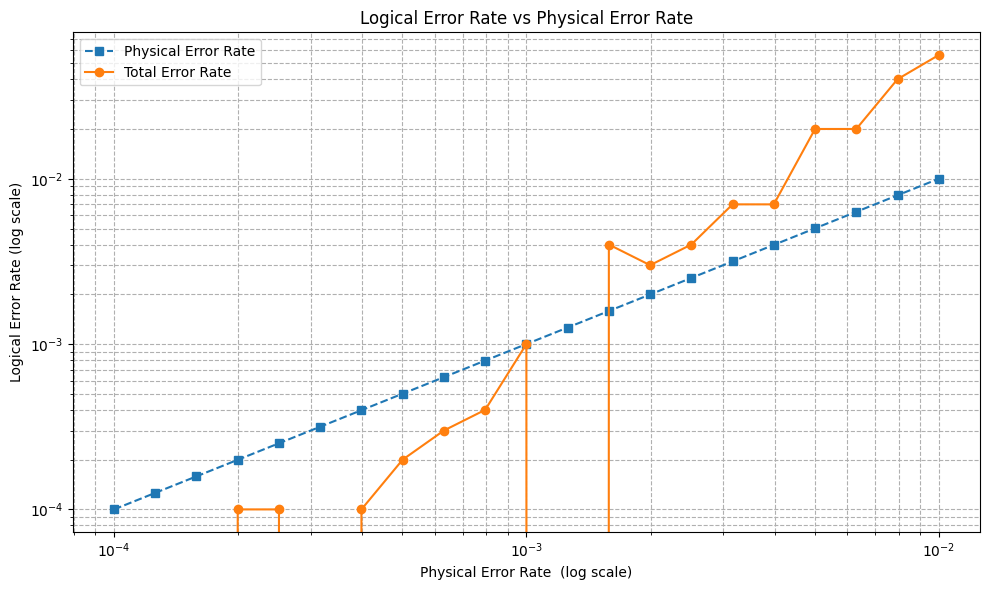

In [25]:
if __name__ == "__main__":
    main()